<div class="alert alert-success">
    <h1 align="center">Lesson 2: Face Recognition (Triplet Loss)</h1>
    <h3 align="center">Javad Mohammadzadeh</h3>
</div>

## Introduction

<h6>Face Recognition:</h6> 
 - Many classes, but very few examples for each class.

## Topics

- Face Recognition
- Siamese Network
- Triplet loss and Contrastive loss
- Defining and implementing our Dataset class.

## Libraries

In [7]:
#utility 
!pip install bcolz
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as T
import bcolz
import os
import sys
import time
import torch.nn as nn
import glob
import shutil
import random
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable



def save_array(fname, arr): 
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

    
def load_array(fname):
    return bcolz.open(fname)[:]


def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)


def create_img_dataloader(image_folder, transform=None, batch_size=25, shuffle=False, num_workers=2):
    if transform is None:
        transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
    img_dataset = datasets.ImageFolder(image_folder, transform)
    img_dataloader = torch.utils.data.DataLoader(img_dataset, batch_size, shuffle, num_workers)
    return img_dataset, img_dataloader

#from utils import to_var


def train_step(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    if scheduler:
        scheduler.step()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = to_var(anc), to_var(pos), to_var(neg)
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        
        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data[0]) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(valid_dl):
        anc = to_var(anc, volatile=True)
        pos = to_var(pos, volatile=True)
        neg = to_var(neg, volatile=True)
        
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data[0]) / (i + 1)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Validation Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler=None, num_epochs=100):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n--------')
        
        model, train_loss = train_step(model, train_dl, criterion, optimizer, scheduler)
        valid_loss = validate_step(model, valid_dl, criterion)
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
            torch.save(best_weights, f'tmp/{cnn_name}-triplet-iranians-{epoch}-{best_loss}.pth')
        print()
        
    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
    return model, loss_history
######


def create_validation_data(trn_dir, val_dir, split=0.1, ext='png'):
    if not os.path.exists(val_dir):
       os.mkdir(val_dir)
        
    train_ds = glob.glob(trn_dir + f'/*/*.{ext}')
    print(len(train_ds))
    
    valid_sz = int(split * len(train_ds)) if split < 1.0 else split 
    
    valid_ds = random.sample(train_ds, valid_sz)
    print(len(valid_ds))
    
    for fname in tqdm(valid_ds):
        basename = os.path.basename(fname)
        label = fname.split('\\')[-2]
        src_folder = os.path.join(trn_dir, label)
        tgt_folder = os.path.join(val_dir, label)
        if not os.path.exists(tgt_folder):
            os.mkdir(tgt_folder)
        shutil.move(os.path.join(src_folder, basename), os.path.join(tgt_folder, basename))
		

def pseudo_label(probs, tst_dir, test_dl, class_names, threshold=0.99999):
    num_data = len(test_dl.dataset)
    preds = np.argmax(probs, axis=1)
    candidate_idxs = np.arange(num_data)[probs.max(axis=1) >= threshold]
    
    fnames = [f[0].split('\\')[-1] for f in test_dl.dataset.imgs]
    imgs = [fnames[i] for i in candidate_idxs]
    labels = [class_names[preds[i]] for i in candidate_idxs]
    
    dest_folder = os.path.join(DATA_DIR, 'pseudo', 'train')
#      for name in class_names:
#          folder = os.path.join(dest_folder, name)
#          if not os.path.exists(folder):
#              os.mkdir(folder)
        
    for _, (img, label) in tqdm(enumerate(zip(imgs, labels))):
        src = os.path.join(tst_dir, 'unk', img)
        dst = os.path.join(dest_folder, label, img)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)
use_gpu = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Helper methods

In [8]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

## Data

Here, we will use [Cambridge AT&T Face Dataset](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html).
- It contains images from 40 different persons.
- For each person, there are 10 different images.

<img src='https://github.com/muhamadzade/Deep_Learning_Week02/blob/main/imgs/ATT_Face_Dataset-4rows.png?raw=1' width='80%'/>

In [17]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

DATA_DIR = '/content/drive/MyDrive/DeepLearning/Week02_Face_recogtition/Dataset2/'
train_dir = f'{DATA_DIR}train'
valid_dir = f'{DATA_DIR}valid'

sz = 200
batch_size = 16
embed_size = 128
num_epochs = 50

cnn_name = 'resnet101'

Mounted at /content/drive


In [16]:
# make validation dataset
#برای دیتاست2 نمیخواهد این کد را اجرا کنیم
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.20, ext='pgm')

### Dataset

In many problems, we need to define our own Dataset class. To define a new Dataset, you should:

1. Create a subclass of `torch.utils.data.Dataset`
2. Override the following three methods:
 - The constructor or `__init__()`: this method is required to initialize the dataset object.
 - The `__getitem__()` method: this methos enables us to access each training data using its index. In other words, we can use the dataset as a simple list or sequence.
 - The `__len__()` method: this method returns number of data in the dataset.

In [18]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform
        if transform is None:
            self.transform = transforms.ToTensor()
        
    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]
        
        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])
        
        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')
        
        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

#### Training data

In [27]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

face_dataset = datasets.ImageFolder(train_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)

#### Validation data

In [26]:
valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=0)

### Visualize dataset

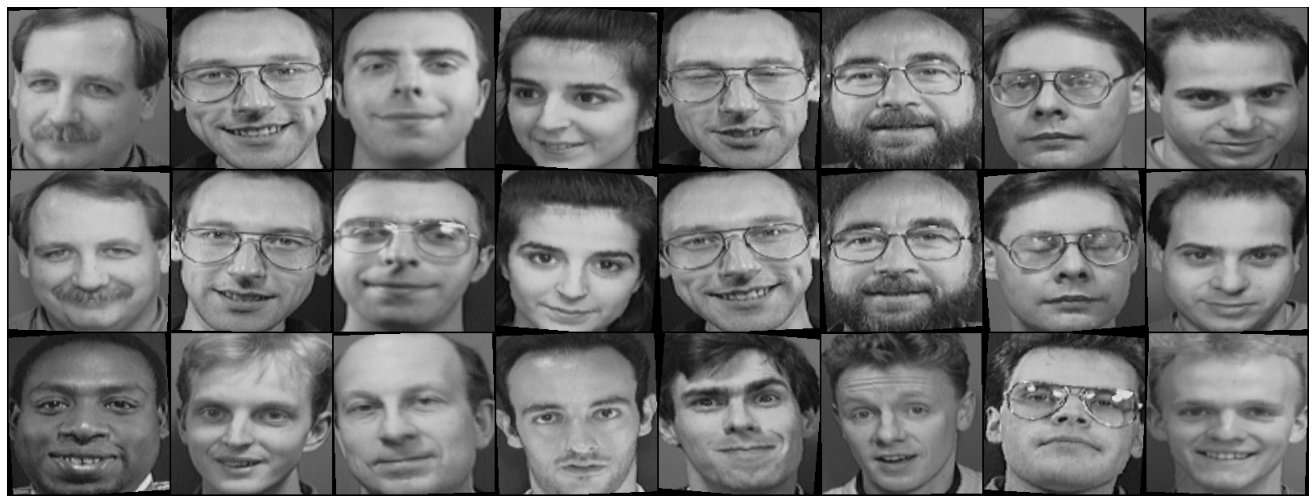

In [28]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 0)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

## Model: Triplet Netwok

In [ ]:
class TripletNetwork(nn.Module):
    
    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

## Loss: Triplet Loss
Given a triplet $(a, p, n)$, the loss is defined as following:

$$L(a, p, n) = \max (\lVert f(a) - f(p) \rVert^2 - \lVert f(a) - f(n) \rVert^2 + \alpha, 0)$$

In wich:
- $a$ is the anchor image
- $p$ is the positive example, and
- $n$ is the negative example.

Also, $f(.)$ is the vector of features extracted from a CNN (i.e., embedding vector).

In [ ]:
class TripletLoss(nn.Module):

    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))
        return loss

## Train

In [ ]:
def train_step(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    if scheduler:
        scheduler.step()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = Variable(anc).cuda(), Variable(pos).cuda(), Variable(neg).cuda()
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        
        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data[0]) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    for i, (anc, pos, neg) in enumerate(valid_dl):
        anc = Variable(anc, volatile=True).cuda()
        pos = Variable(pos, volatile=True).cuda()
        neg = Variable(neg, volatile=True).cuda()
        
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.data[0]) / (i + 1)
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler=None, num_epochs=100):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n--------')
        model, train_loss = train_step(model, train_dl, criterion, optimizer, scheduler)
        valid_loss = validate_step(model, valid_dl, criterion)
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    return model, best_weights, loss_history

In [ ]:
# data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# model
cnn = get_model(cnn_name)
model = TripletNetwork(cnn, embed_size).cuda()

# loss and optimizer
criterion = TripletLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

## Training

In [ ]:
model, best_weights, loss_hist = train(model, train_dl, valid_dl, 
                                       criterion, optimizer, scheduler, 
                                       num_epochs=num_epochs)

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

In [ ]:
torch.save(model.state_dict(), f'{cnn_name}-facereco-triplet-{num_epochs}.pth')

## Testing

In [ ]:
model.load_state_dict(torch.load('weights/resnet101-facereco-triplet-50.pth'))

In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

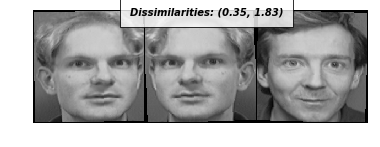

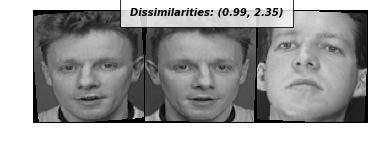

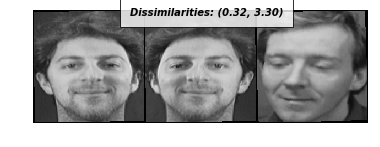

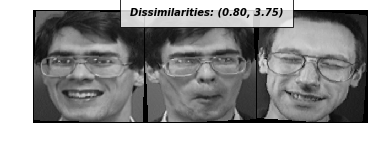

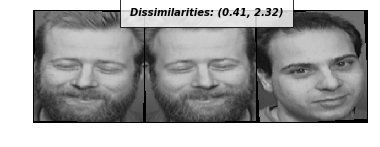

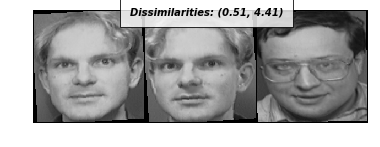

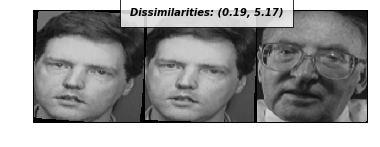

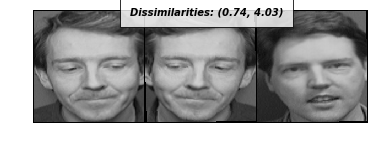

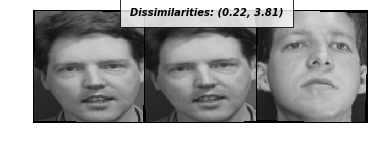

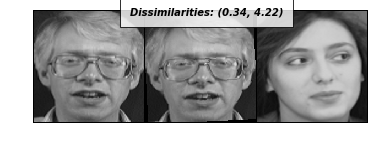

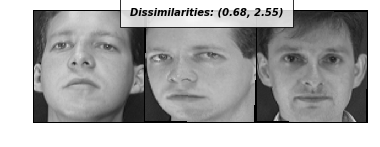

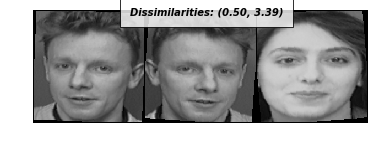

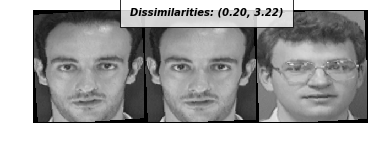

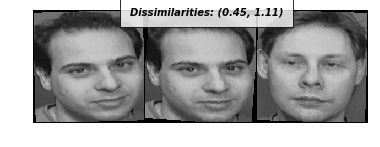

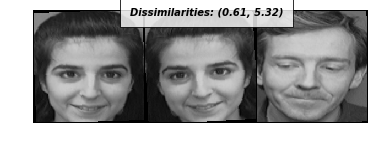

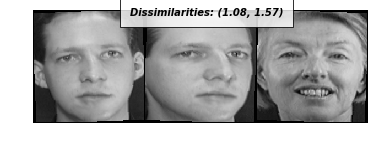

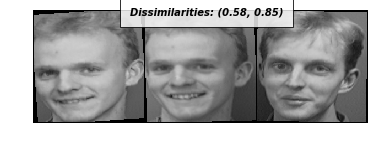

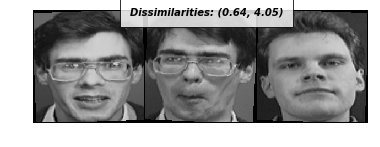

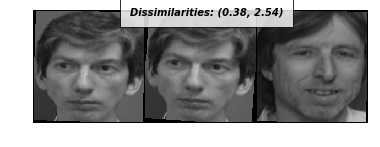

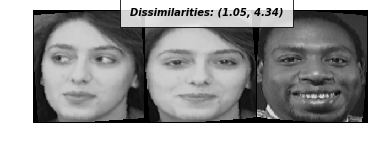

In [ ]:
model.eval()

dataiter = iter(valid_dl)
for i in range(20):
    x0, x1, x2 = next(dataiter)
    concat = torch.cat((x0, x1, x2), 0)
    f0, f1, f2 = model(Variable(x0).cuda(), Variable(x1).cuda(), Variable(x2).cuda())
    pos_distance = F.pairwise_distance(f0, f1)
    neg_distance = F.pairwise_distance(f0, f2)
    imshow(torchvision.utils.make_grid(concat), 'Dissimilarities: ({:.2f}, {:.2f})'.format(pos_distance.cpu().data.numpy()[0][0], 
                                                                                           neg_distance.cpu().data.numpy()[0][0]))